## Vorticity budgets in 1/4$^{\circ}$ vs 1/8$^{\circ}$

In this notebook, we compare the vorticity budget terms in simulations having two different resolutions. The budget terms are interpolated on the same grid for easier comparison. Moreoever, the effect of spatial filtering is also examined.

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import xesmf as xe
import gcm_filters
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

client

Client Scheduler: tcp://127.0.0.1:33332 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 406.01 GB


In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

#### Read Data

In [3]:
ppdir = "/archive/Hemant.Khatri/MOM_Budget/"

ds_p25 = xr.open_dataset(ppdir + "OM4p25/OM4p25_Vorticity_Budget.nc", decode_times = False, chunks = {'time':1})
#{'xq':720, 'yq':360, 'xh':720, 'yh':360})

ds_p125 = xr.open_dataset(ppdir + "OM4p125/OM4p125_Vorticity_Budget.nc", decode_times = False, chunks = {'time':1})
#{'xq':720, 'yq':360, 'xh':720, 'yh':360})

# take time-mean for 100 - 145 years

ds_p25 = ds_p25.isel(time = slice(20, 29)).mean('time')
ds_p125 = ds_p125.isel(time = slice(20, 29)).mean('time')

In [4]:
print(ds_p125)

<xarray.Dataset>
Dimensions:       (xh: 2880, xq: 2880, yh: 2240, yq: 2240)
Coordinates:
  * xh            (xh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * yh            (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.86 89.92 89.97
  * xq            (xq) float64 -298.5 -298.4 -298.3 -298.2 ... 61.12 61.23 61.35
  * yq            (yq) float64 -83.6 -83.56 -83.52 -83.48 ... 89.89 89.95 90.0
Data variables:
    ssh           (yh, xh) float32 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
    beta_V        (yq, xq) float32 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
    BPT           (yq, xq) float64 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
    Curl_Adv      (yq, xq) float64 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
    Curl_taus     (yq, xq) float64 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
    Curl_taub     (yq, xq) float64 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
    Curl_diff     (yq, xq) float64 dask.array<chunks

#### Create regridder to 0.5$^{\circ}$ x 0.5$^{\circ}$ 

In [5]:
def grid_model_sym_approx(ds):
    grid_model = xr.Dataset()
    grid_model['lon'] = ds['geolon']
    grid_model['lat'] = ds['geolat']

    ny, nx = grid_model['lon'].shape

    lon_b = np.empty((ny+1, nx+1))
    lat_b = np.empty((ny+1, nx+1))

    lon_b[1:, 1:] = ds['geolon_c'].values
    lat_b[1:, 1:] = ds['geolat_c'].values

    # periodicity
    lon_b[:, 0] = 360 - lon_b[:, -1]
    lat_b[:, 0] = lat_b[:, -1]

    # south edge
    dy = (lat_b[2,:] - lat_b[1,:]).mean()
    lat_b[0, 1:] = lat_b[1,1:] - dy
    lon_b[0, 1:] = lon_b[1, 1:]

    # corner point
    lon_b[0, 0] = lon_b[1,0]
    lat_b[0,0] = lat_b[0,1]

    grid_model['lon_b'] = xr.DataArray(data=lon_b, dims=('yq','xq'))
    grid_model['lat_b'] = xr.DataArray(data=lat_b, dims=('yq','xq'))
    return grid_model

In [6]:
# remap to 0.5x0.5 deg

#ds_out = xr.Dataset()
#ds_out['lon'] = xr.DataArray(data=0.5 + np.arange(360), dims=('x'))
#ds_out['lat'] = xr.DataArray(data=0.5 -90 + np.arange(180), dims=('y'))
#ds_out['lon_b'] = xr.DataArray(data=np.arange(361), dims=('xp'))
#ds_out['lat_b'] = xr.DataArray(data=-90 + np.arange(181), dims=('yp'))

ds_out = xe.util.grid_global(0.5, 0.5)

grid_model = grid_model_sym_approx(ds_p25)
%time regrid_p25 = xe.Regridder(grid_model, ds_out, 'bilinear', reuse_weights=True, periodic=True)

grid_model = grid_model_sym_approx(ds_p125)
%time regrid_p125 = xe.Regridder(grid_model, ds_out, 'bilinear', reuse_weights=True, periodic=True)

# there is some bug in conservative scheme

Create weight file: bilinear_1080x1440_360x720_peri.nc
CPU times: user 2min 16s, sys: 12.2 s, total: 2min 28s
Wall time: 2min 37s
Create weight file: bilinear_2240x2880_360x720_peri.nc
CPU times: user 4min 11s, sys: 19.1 s, total: 4min 30s
Wall time: 4min 22s


In [7]:
print(ds_out)

<xarray.Dataset>
Dimensions:  (x: 720, x_b: 721, y: 360, y_b: 361)
Coordinates:
    lon      (y, x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    lat      (y, x) float64 -89.75 -89.75 -89.75 -89.75 ... 89.75 89.75 89.75
    lon_b    (y_b, x_b) float64 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*


#### Filter using $2^{\circ}$ and $5^{\circ}$ Guassian kernels

In [8]:
%%time 

fldlist = ['beta_V', 'BPT','Mass_flux','eta_dt','Curl_dudt','Curl_taus','Curl_taub','Curl_Adv','Curl_diff']
dims = ['yq', 'xq']

# ------------ 1/4 deg data filter ------------------
ds_p25_2Deg = xr.Dataset() # new xarray dataset for Gaussian-filtered fields 
ds_p25_5Deg = xr.Dataset()

ds1 = ds_p25.astype(np.float64)
area = ds1['areacello_bu']
wet_mask = ds1['wet_c']

# guassian filter over 2 deg diameter
filter_2Deg = gcm_filters.Filter(filter_scale=8, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

for fld in fldlist:
    
    tmp = filter_2Deg.apply(ds1[fld] * area, dims=dims)
    ds_p25_2Deg[fld] = (tmp/area).load().assign_coords({'geolat_c': ds1['geolat_c'], 'geolon_c': ds1['geolon_c']})
    
# guassian filter over 5 deg diameter
filter_5Deg = gcm_filters.Filter(filter_scale=20, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

for fld in fldlist:
    
    tmp = filter_5Deg.apply(ds1[fld] * area, dims=dims)
    ds_p25_5Deg[fld] = (tmp/area).load().assign_coords({'geolat_c': ds1['geolat_c'], 'geolon_c': ds1['geolon_c']})

# ------- 1/8 deg data filter ----------------------
ds_p125_2Deg = xr.Dataset()
ds_p125_5Deg = xr.Dataset()

ds1 = ds_p125.astype(np.float64)
area = ds1['areacello_bu']
wet_mask = ds1['wet_c']

# guassian filter over 2 deg diameter
filter_2Deg = gcm_filters.Filter(filter_scale=16, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

for fld in fldlist:
    
    tmp = filter_2Deg.apply(ds1[fld] * area, dims=dims)
    ds_p125_2Deg[fld] = (tmp/area).load().assign_coords({'geolat_c': ds1['geolat_c'], 'geolon_c': ds1['geolon_c']})
    
# guassian filter over 5 deg diameter
filter_5Deg = gcm_filters.Filter(filter_scale=40, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

for fld in fldlist:
    
    tmp = filter_5Deg.apply(ds1[fld] * area, dims=dims)
    ds_p125_5Deg[fld] = (tmp/area).load().assign_coords({'geolat_c': ds1['geolat_c'], 'geolon_c': ds1['geolon_c']})
    

CPU times: user 19.2 s, sys: 3.9 s, total: 23.1 s
Wall time: 6min 22s


In [9]:
print(ds_p25_2Deg)

<xarray.Dataset>
Dimensions:    (xq: 1440, yq: 1080)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
    geolat_c   (yq, xq) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    geolon_c   (yq, xq) float64 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Data variables:
    beta_V     (yq, xq) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    BPT        (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Mass_flux  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eta_dt     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_dudt  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taus  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taub  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_Adv   (yq, xq) float64 nan

#### Regrid filtered data to $1^{\circ}\times 1^{\circ}$ for comparison

In [10]:
ds_p25_2Deg_regrid = regrid_p25(ds_p25_2Deg)
#ds_p25_2Deg_regrid.coords['x'] = ds_p25_2Deg_regrid.lon.values[:]
#ds_p25_2Deg_regrid.coords['y'] = ds_p25_2Deg_regrid.lat.values[:]
ds_p25_2Deg_regrid.coords['x'] = ds_p25_2Deg_regrid.lon.values[0,:]
ds_p25_2Deg_regrid.coords['y'] = ds_p25_2Deg_regrid.lat.values[:,0]

ds_p25_5Deg_regrid = regrid_p25(ds_p25_5Deg)
#ds_p25_5Deg_regrid.coords['x'] = ds_p25_5Deg_regrid.lon.values[:]
#ds_p25_5Deg_regrid.coords['y'] = ds_p25_5Deg_regrid.lat.values[:]
ds_p25_5Deg_regrid.coords['x'] = ds_p25_5Deg_regrid.lon.values[0,:]
ds_p25_5Deg_regrid.coords['y'] = ds_p25_5Deg_regrid.lat.values[:,0]

ds_p125_2Deg_regrid = regrid_p125(ds_p125_2Deg)
#ds_p125_2Deg_regrid.coords['x'] = ds_p125_2Deg_regrid.lon.values[:]
#ds_p125_2Deg_regrid.coords['y'] = ds_p125_2Deg_regrid.lat.values[:]
ds_p125_2Deg_regrid.coords['x'] = ds_p125_2Deg_regrid.lon.values[0,:]
ds_p125_2Deg_regrid.coords['y'] = ds_p125_2Deg_regrid.lat.values[:,0]

ds_p125_5Deg_regrid = regrid_p125(ds_p125_5Deg)
#ds_p125_5Deg_regrid.coords['x'] = ds_p125_5Deg_regrid.lon.values[:]
#ds_p125_5Deg_regrid.coords['y'] = ds_p125_5Deg_regrid.lat.values[:]
ds_p125_5Deg_regrid.coords['x'] = ds_p125_5Deg_regrid.lon.values[0,:]
ds_p125_5Deg_regrid.coords['y'] = ds_p125_5Deg_regrid.lat.values[:,0]

using dimensions ('yq', 'xq') from data variable beta_V as the horizontal dimensions for this dataset.
using dimensions ('yq', 'xq') from data variable beta_V as the horizontal dimensions for this dataset.
using dimensions ('yq', 'xq') from data variable beta_V as the horizontal dimensions for this dataset.
using dimensions ('yq', 'xq') from data variable beta_V as the horizontal dimensions for this dataset.


In [11]:
print(ds_p25_2Deg_regrid)

<xarray.Dataset>
Dimensions:    (x: 720, y: 360)
Coordinates:
    lon        (y, x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    lat        (y, x) float64 -89.75 -89.75 -89.75 -89.75 ... 89.75 89.75 89.75
  * x          (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y          (y) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    beta_V     (y, x) float64 0.0 0.0 0.0 0.0 ... 2.924e-12 2.985e-12 3.046e-12
    BPT        (y, x) float64 nan nan nan nan ... 5.156e-10 5.207e-10 5.256e-10
    Mass_flux  (y, x) float64 nan nan nan nan ... 1.944e-12 1.944e-12 1.943e-12
    eta_dt     (y, x) float64 nan nan nan nan ... 1.738e-15 1.734e-15 1.73e-15
    Curl_dudt  (y, x) float64 nan nan nan ... -2.786e-12 -2.773e-12 -2.759e-12
    Curl_taus  (y, x) float64 nan nan nan ... -8.916e-11 -9.081e-11 -9.245e-11
    Curl_taub  (y, x) float64 nan nan nan ... -3.155e-10 -3.182e-10 -3.21e-10
    Curl_Adv   (y, x) float64 nan nan nan ... -4.686e

#### Plot and compare

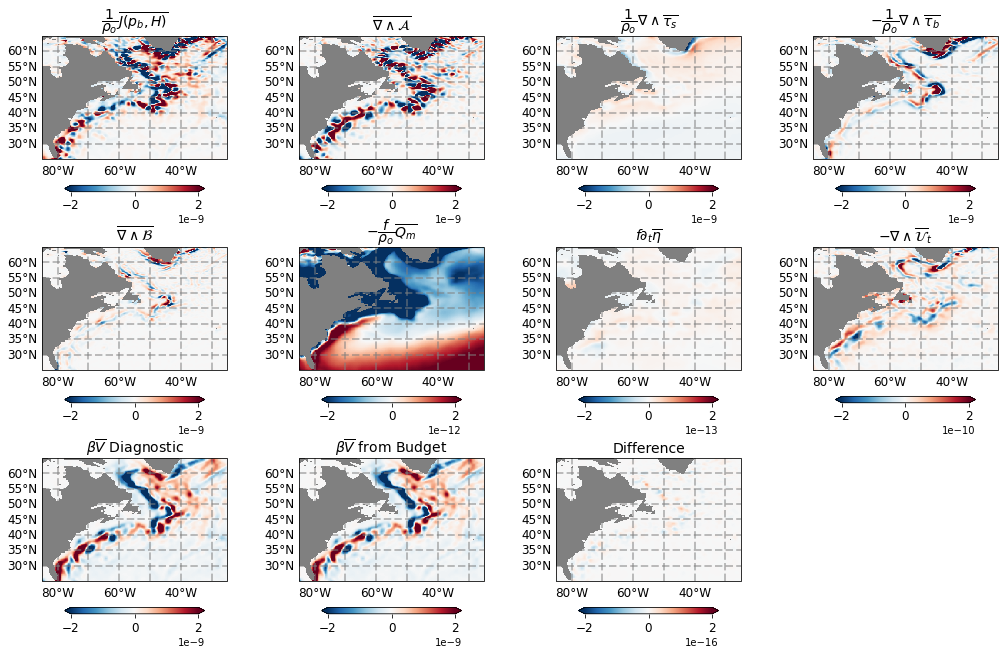

In [21]:
# 50-yr average plot

max_r = 2.e-9
lat_lon_ext = [-85., -25., 25., 65.]

BPT_g = ds_p25_2Deg.sel(yq = slice(0,80.), xq = slice(-100, 10.))

grid1 = plt.GridSpec(3, 4, wspace=0.1, hspace=0.2)
fig = plt.figure(figsize=[18,11])

BPT1 = BPT_g['BPT']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_diff'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{B}}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Mass_flux'], vmin=-0.001*max_r, vmax=0.001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \dfrac{f}{\rho_o}\overline{Q_m}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['eta_dt'], vmin=-0.0001*max_r, vmax=0.0001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ f\partial_t\overline{\eta}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t$')

beta_V = BPT_g['beta_V'] / (ds_p25['wet_c'].sel(yq = slice(0,80.), xq = slice(-100, 10.)))
ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, beta_V, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic')

tmp = (BPT1 + BPT_g['Curl_Adv'] + BPT_g['Curl_taus'] + BPT_g['Curl_taub'] +
      BPT_g['Curl_diff'] + BPT_g['Mass_flux'] + BPT_g['eta_dt'] + BPT_g['Curl_dudt'])
ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ from Budget')

ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp - beta_V, vmin=-1e-7*max_r, vmax=1e-7*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Difference')

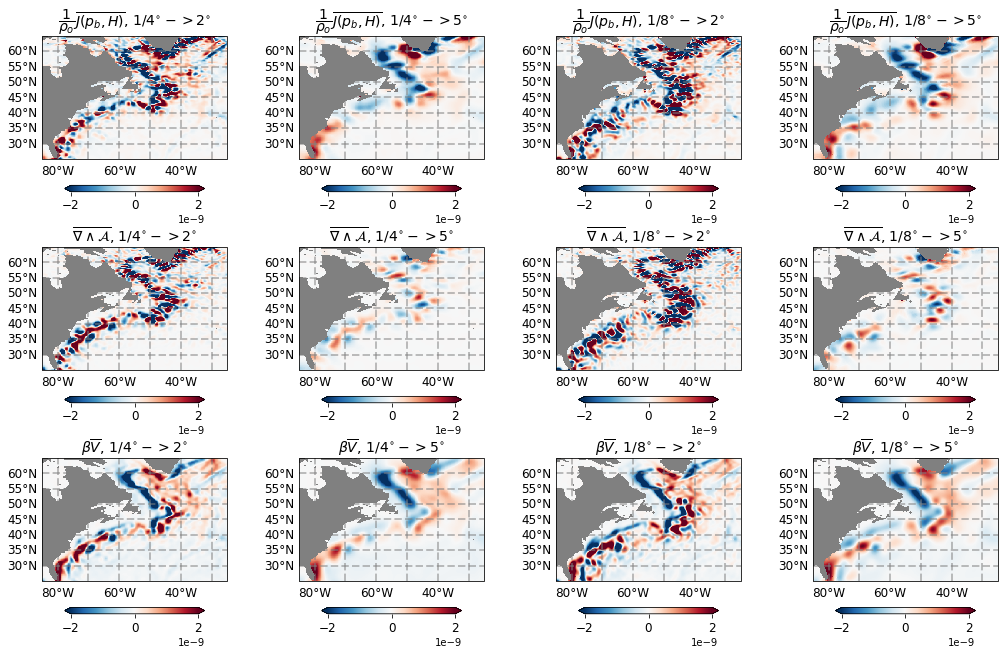

In [22]:
# Compare Filtering effect
max_r = 2.e-9
lat_lon_ext = [-85., -25., 25., 65.]

d25_2D = ds_p25_2Deg.sel(yq = slice(0,80.), xq = slice(-100, 10.))
d125_2D = ds_p125_2Deg.sel(yq = slice(0,80.), xq = slice(-100, 10.))
d25_5D = ds_p25_5Deg.sel(yq = slice(0,80.), xq = slice(-100, 10.))
d125_5D = ds_p125_5Deg.sel(yq = slice(0,80.), xq = slice(-100, 10.))

grid1 = plt.GridSpec(3, 4, wspace=0.1, hspace=0.2)
fig = plt.figure(figsize=[18,11])

BPT1 = d25_2D['BPT']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$, $1/4^{\circ} -> 2^{\circ}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25_2D['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$, $1/4^{\circ} -> 2^{\circ}$')

beta_V = d25_2D['beta_V'] / (ds_p25['wet_c'].sel(yq = slice(0,80.), xq = slice(-100, 10.)))
ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, beta_V, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$, $1/4^{\circ} -> 2^{\circ}$')

BPT1 = d25_5D['BPT']
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$, $1/4^{\circ} -> 5^{\circ}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25_5D['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$, $1/4^{\circ} -> 5^{\circ}$')

beta_V = d25_5D['beta_V'] / (ds_p25['wet_c'].sel(yq = slice(0,80.), xq = slice(-100, 10.)))
ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, beta_V, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$, $1/4^{\circ} -> 5^{\circ}$')



BPT1 = d125_2D['BPT']
ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$, $1/8^{\circ} -> 2^{\circ}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125_2D['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$, $1/8^{\circ} -> 2^{\circ}$')

beta_V = d125_2D['beta_V'] / (ds_p125['wet_c'].sel(yq = slice(0,80.), xq = slice(-100, 10.)))
ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, beta_V, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$, $1/8^{\circ} -> 2^{\circ}$')

BPT1 = d125_5D['BPT']
ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$, $1/8^{\circ} -> 5^{\circ}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125_5D['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$, $1/8^{\circ} -> 5^{\circ}$')

beta_V = d125_5D['beta_V'] / (ds_p125['wet_c'].sel(yq = slice(0,80.), xq = slice(-100, 10.)))
ax = fig.add_subplot(grid1[2, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, beta_V, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$, $1/8^{\circ} -> 5^{\circ}$')

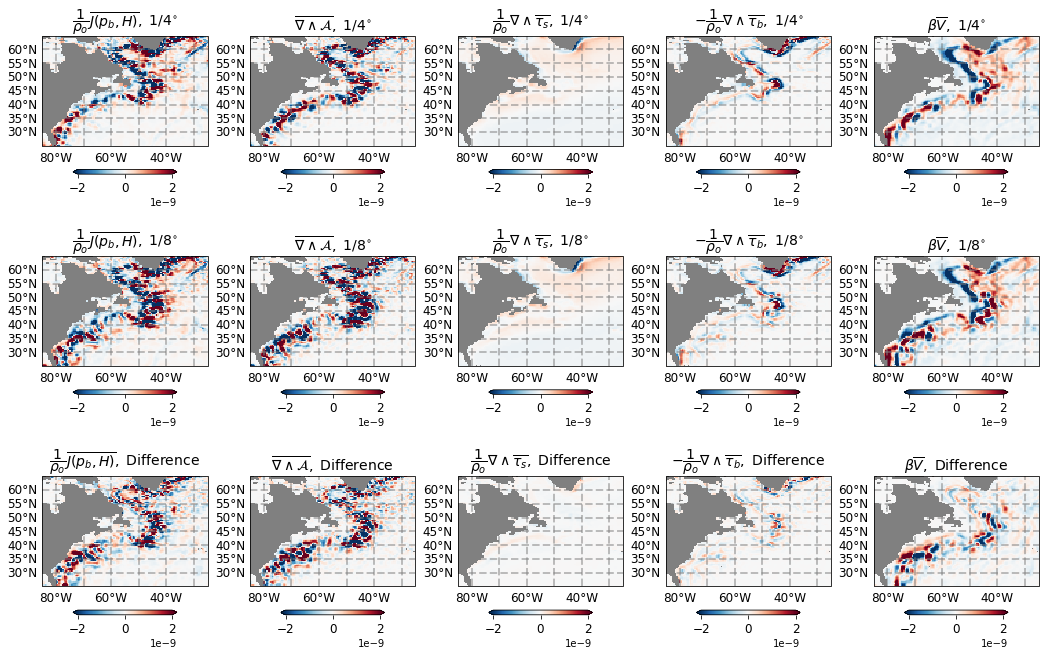

In [34]:
max_r = 2.e-9
max_r1 = 2.e-9
lat_lon_ext = [-85., -25., 25., 65.]

d25 = ds_p25_2Deg_regrid #.sel(y = slice(0,80.), x = slice(-100, 10.))
d125 = ds_p125_2Deg_regrid #.sel(y = slice(0,80.), x = slice(-100, 10.))

grid1 = plt.GridSpec(3, 5, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[18,11])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ $1/4^{\circ}$')

tmp_25 = (d25['BPT'] + d25['Curl_Adv'] + d25['Curl_taus'] + d25['Curl_taub'] +
      d25['Curl_diff'] + d25['Mass_flux'] + d25['eta_dt'] + d25['Curl_dudt'])
ax = fig.add_subplot(grid1[0, 4], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp_25, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\beta \overline{V},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ $1/8^{\circ}$')

tmp_125 = (d125['BPT'] + d125['Curl_Adv'] + d125['Curl_taus'] + d125['Curl_taub'] +
      d125['Curl_diff'] + d125['Mass_flux'] + d125['eta_dt'] + d125['Curl_dudt'])
ax = fig.add_subplot(grid1[1, 4], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp_125, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\beta \overline{V},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['BPT'] - d125['BPT'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ Difference')

ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_Adv'] - d125['Curl_Adv'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}},$ Difference')

ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taus'] - d125['Curl_taus'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ Difference')

ax = fig.add_subplot(grid1[2, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taub'] - d125['Curl_taub'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ Difference')

ax = fig.add_subplot(grid1[2, 4], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp_25 - tmp_125, vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\beta \overline{V},$ Difference')

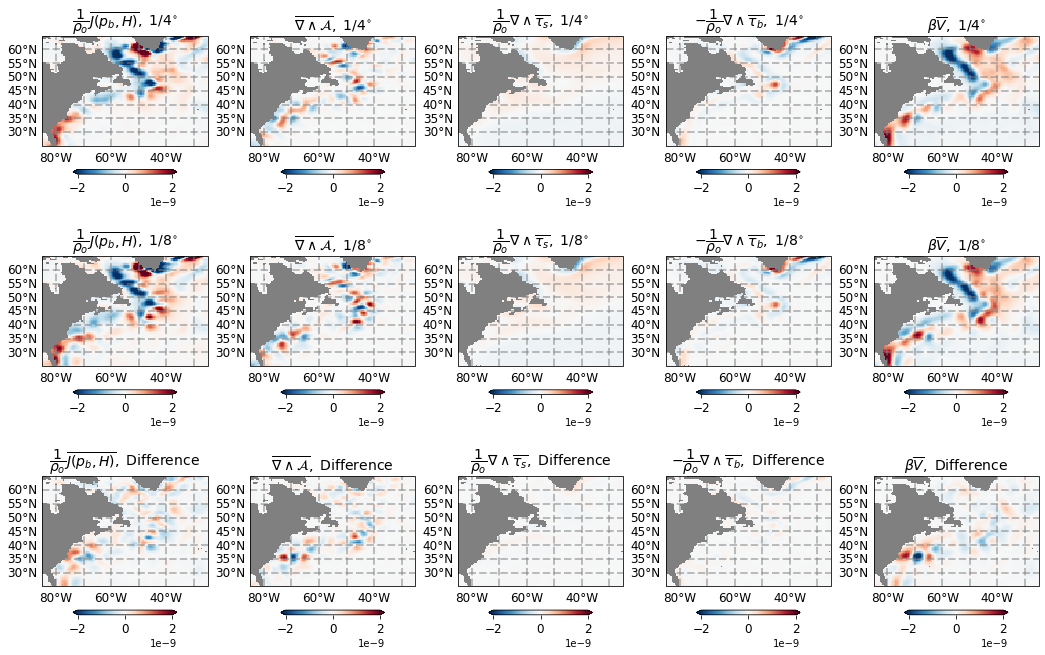

In [35]:
max_r = 2.e-9
max_r1 = 2.e-9
lat_lon_ext = [-85., -25., 25., 65.]

d25 = ds_p25_5Deg_regrid #.sel(y = slice(0,80.), x = slice(-100, 10.))
d125 = ds_p125_5Deg_regrid #.sel(y = slice(0,80.), x = slice(-100, 10.))

grid1 = plt.GridSpec(3, 5, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[18,11])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ $1/4^{\circ}$')

tmp_25 = (d25['BPT'] + d25['Curl_Adv'] + d25['Curl_taus'] + d25['Curl_taub'] +
      d25['Curl_diff'] + d25['Mass_flux'] + d25['eta_dt'] + d25['Curl_dudt'])
ax = fig.add_subplot(grid1[0, 4], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp_25, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\beta \overline{V},$ $1/4^{\circ}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d125['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ $1/8^{\circ}$')

tmp_125 = (d125['BPT'] + d125['Curl_Adv'] + d125['Curl_taus'] + d125['Curl_taub'] +
      d125['Curl_diff'] + d125['Mass_flux'] + d125['eta_dt'] + d125['Curl_dudt'])
ax = fig.add_subplot(grid1[1, 4], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp_125, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\beta \overline{V},$ $1/8^{\circ}$')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['BPT'] - d125['BPT'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)},$ Difference')

ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_Adv'] - d125['Curl_Adv'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}},$ Difference')

ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taus'] - d125['Curl_taus'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}},$ Difference')

ax = fig.add_subplot(grid1[2, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, d25['Curl_taub'] - d125['Curl_taub'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}},$ Difference')

ax = fig.add_subplot(grid1[2, 4], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp_25 - tmp_125, vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='RdBu_r', title=r'$\beta \overline{V},$ Difference')

#### Global plots with 5$^{\circ}$ filter

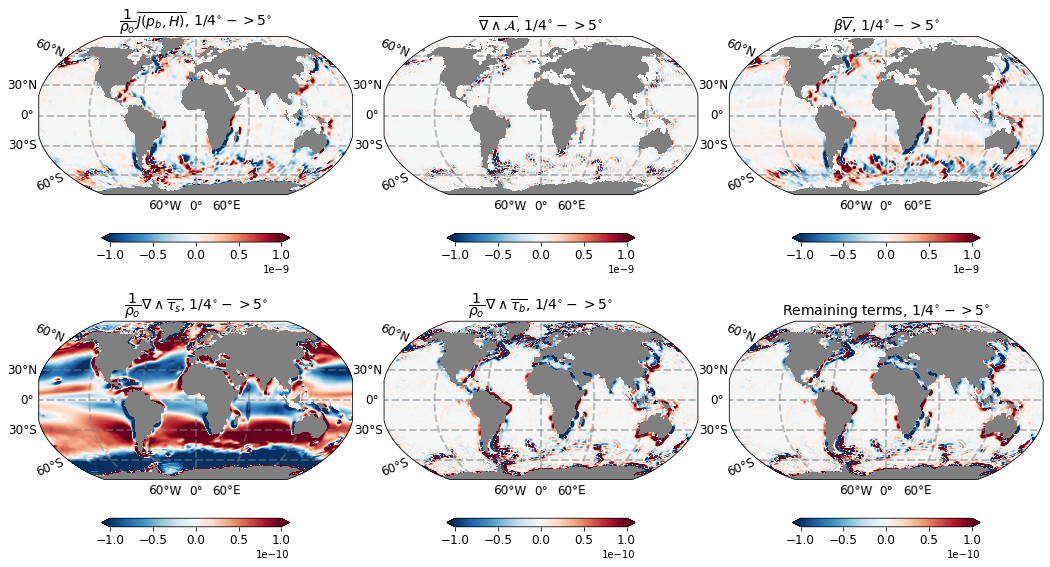

In [15]:
max_r = 1.e-9
max_r1 = 1.e-10

grid1 = plt.GridSpec(2, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,10])

lat_lon_ext = [-180, 180, -85., 85.]

d25_5D = ds_p25_5Deg

BPT1 = d25_5D['BPT']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$, $1/4^{\circ} -> 5^{\circ}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, d25_5D['Curl_Adv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$, $1/4^{\circ} -> 5^{\circ}$')

beta_V = d25_5D['beta_V'] / (ds_p25['wet_c'])
ax = fig.add_subplot(grid1[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, beta_V, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$, $1/4^{\circ} -> 5^{\circ}$')


ax = fig.add_subplot(grid1[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, d25_5D['Curl_taus'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}}$, $1/4^{\circ} -> 5^{\circ}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, d25_5D['Curl_taub'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}}$, $1/4^{\circ} -> 5^{\circ}$')

tmp = d25_5D['Curl_diff'] + d25_5D['Mass_flux'] + d25_5D['eta_dt'] + d25_5D['Curl_dudt']
ax = fig.add_subplot(grid1[1, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, d25_5D['Curl_taub'], vmin=-max_r1, vmax=max_r1, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Remaining terms, $1/4^{\circ} -> 5^{\circ}$')

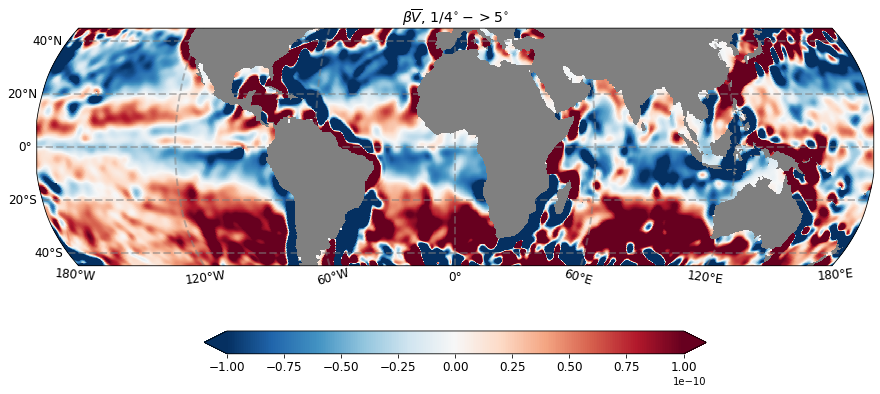

In [16]:
max_r = 1.e-10

grid1 = plt.GridSpec(1, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[15,8])

lat_lon_ext = [-180, 180, -45., 45.]

d25_5D = ds_p25_5Deg

beta_V = d25_5D['beta_V'] / (ds_p25['wet_c'])
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, beta_V, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$, $1/4^{\circ} -> 5^{\circ}$')

In [17]:
client.close()
cluster.close()